In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [61]:
df = pd.read_csv('./dataset/dataset/transfers.csv')
dataset = df[df['dir'] == 'in']

In [62]:
# rimuovi i 6 player che non hanno età
dataset.dropna(subset=['player_age'], inplace=True)
# sostituisci i valori di trasferimento Nan con 0
dataset['transfer_fee_amnt'].fillna(0, inplace=True)
# sostituisci i valori di valore di mercato Nan con 0
dataset['market_val_amnt'].fillna(0, inplace=True)
# rimuovi i trasferimenti senza squadra di destinazione (ovvero svincoli)
dataset = dataset[dataset['counter_team_name'] != 'Without Club'] 
# rimuovi i trasferimenti senza squadra di provenienza (ovvero ingaggio di svincolati)
dataset = dataset[dataset['team_name'] != 'Without Club']
# Rimuovi le righe in cui 'team_id' o 'counter_team_id' sono uguali a 'Retired'
dataset = dataset[(dataset['team_id'] != 'Retired') & (dataset['counter_team_id'] != 'Retired')]
# Rimozione dei rientri dal prestito (is_loan_end = True)
dataset = dataset[dataset['is_loan_end'] == False]

# Conversione dei valori di 'team_id' e 'counter_team_id' in interi
dataset['team_id'] = dataset['team_id'].astype(int)
dataset['counter_team_id'] = dataset['counter_team_id'].astype(int)


print('Il dataset è composto da ', dataset.shape[0], ' trasferimenti')

Il dataset è composto da  22696  trasferimenti


/var/folders/61/9rphml817c1d45n8g26p1ltm0000gn/T/ipykernel_1319/3190214965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(subset=['player_age'], inplace=True)
/var/folders/61/9rphml817c1d45n8g26p1ltm0000gn/T/ipykernel_1319/3190214965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['transfer_fee_amnt'].fillna(0, inplace=True)
/var/folders/61/9rphml817c1d45n8g26p1ltm0000gn/T/ipykernel_1319/3190214965.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [76]:
G = nx.MultiDiGraph()

for index, row in dataset.iterrows():
    player_name = row['player_name']
    
    # Utilizza l'ID della squadra come identificatore del nodo
    team1 = row['team_id']
    team2 = row['counter_team_id']
    
    if not G.has_node(team1):
        G.add_node(team1, label='team', name=row['team_name'], country=row['team_country'])
    if not G.has_node(team2):
        G.add_node(team2, label='team', name=row['counter_team_name'], country=row['counter_team_country'])
    
    transfer_attributes = {
        'transfer_id': row['transfer_id'],
        'player_id': row['player_id'],
        'player_name': row['player_name'],
        'player_age': row['player_age'],
        'season': row['season'],
        'window': row['window'],
        'transfer_fee_amnt': row['transfer_fee_amnt'],
        'is_loan': row['is_loan'],
        'market_val_amnt': row['market_val_amnt']
    }
    
    G.add_edge(team2, team1, label='transfer', **transfer_attributes) 

print('Numero di nodi:', G.number_of_nodes())
print('Numero di archi:', G.number_of_edges())


Numero di nodi: 2193
Numero di archi: 22696


In [77]:
# Calcola il grado dei nodi in ingresso e in uscita
in_degree = G.in_degree()
out_degree = G.out_degree()

# Crea un elenco dei nodi (team) che soddisfano il criterio di avere almeno un arco in ingresso e uno in uscita 
selected_teams = [node for node in G.nodes() if out_degree[node] > 0 and in_degree[node] > 0 ] 

print('Nodi selezionati -> ', len(selected_teams), ' nodi con almeno 10 operazioni di mercato')

# Crea un nuovo grafo (sottografo) basato sui nodi selezionati
net = G.subgraph(selected_teams)

net = net.copy()

# Identifica i nodi che soddisfano il criterio (transfer_fee_amnt uguale a 0 per tutti gli archi uscenti e entranti)
nodes_to_remove = []
for node in net.nodes():
    out_edges = net.out_edges(node, data=True)
    in_edges = net.in_edges(node, data=True)
        
    if all(attr['transfer_fee_amnt'] == 0 for _, _, attr in out_edges) and all(attr['transfer_fee_amnt'] == 0 for _, _, attr in in_edges):
        nodes_to_remove.append(node)

print('Nodi da rimuovere -> ', len(nodes_to_remove), ' nodi con tutte le operazioni di mercato a 0')

net.remove_nodes_from(nodes_to_remove)

print('Nodi -> ', net.number_of_nodes())
print('Archi -> ', net.number_of_edges())
print('Density -> ', nx.density(net))

Nodi selezionati ->  239  nodi con almeno 10 operazioni di mercato
Nodi da rimuovere ->  3  nodi con tutte le operazioni di mercato a 0
Nodi ->  236
Archi ->  11648
Density ->  0.21002524341868012


/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

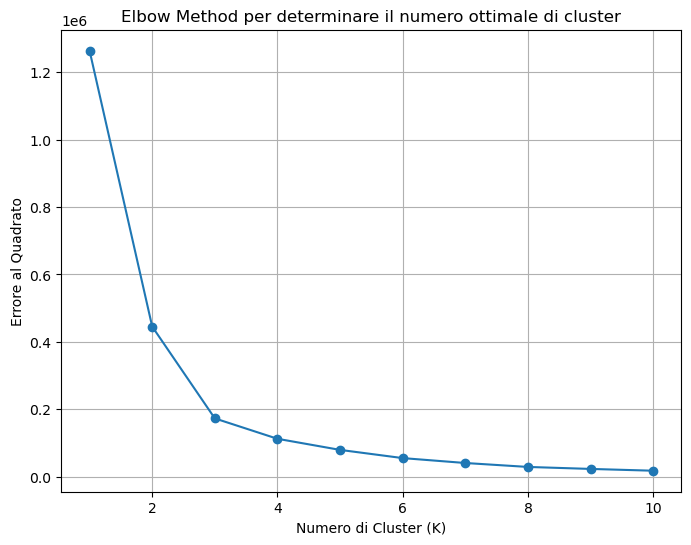

In [78]:
###### CALCOLO DEL K MIGLIORE ######

from sklearn.cluster import KMeans
import numpy as np

# Ottieni il grafo dei nodi
degrees = dict(net.degree())

# Estrai i gradi in una lista per usarli nel K-Means
degree_values = list(degrees.values())

# Inizializza una lista vuota per memorizzare l'errore al quadrato
inertia = []

# Esegui K-Means per un intervallo di valori di K
for k in range(1, 11):  # Prova da 1 a 10 cluster
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(np.array(degree_values).reshape(-1, 1))
    inertia.append(kmeans.inertia_)

# Disegna il grafico dell'errore al quadrato in funzione di K
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Numero di Cluster (K)')
plt.ylabel('Errore al Quadrato')
plt.title('Elbow Method per determinare il numero ottimale di cluster')
plt.grid()
plt.show()

/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


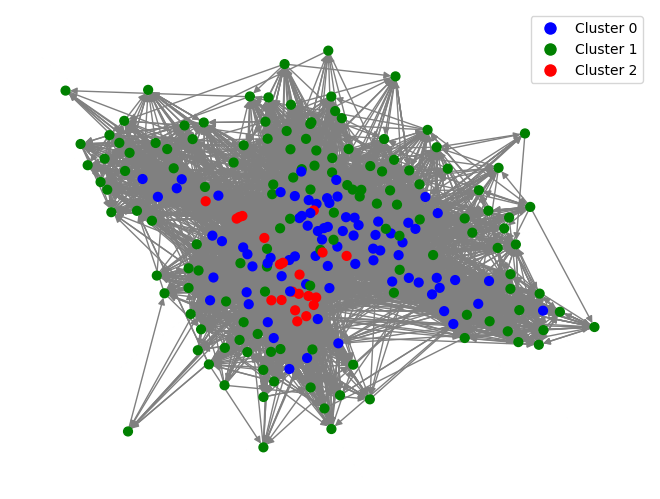

In [79]:

# Ottieni il grafo dei nodi 
degrees = dict(net.degree())

# Estrai i gradi in una lista per usarli nel kmeans
degree_values = list(degrees.values())

# Esegui il kmeans con 3 cluster
kmeans = KMeans(n_clusters=3)

# Addestra il modello utilizzando la lista di gradi
kmeans.fit(np.array(degree_values).reshape(-1, 1))

# Ottieni le etichette dei cluster per ogni nodo
cluster_labels = kmeans.labels_

# Aggiungi le etichette dei cluster come attributo ai nodi
for node, label in zip(net.nodes(), cluster_labels):
    net.nodes[node]['cluster'] = label

#################  Rappresentazione del grafo  #################

# Definisci una lista di colori per i cluster
cluster_colors = ['b', 'g', 'r']

# Crea un dizionario che mappa i cluster alle rispettive etichette dei colori
cluster_color_mapping = {cluster: color for cluster, color in enumerate(cluster_colors)}

# Estrai gli attributi dei cluster dai nodi
cluster_labels = nx.get_node_attributes(net, 'cluster')

# Crea una lista di colori per ogni nodo basata sui cluster
node_colors = [cluster_color_mapping[cluster_labels[node]] for node in net.nodes()]

# Disegna il grafo utilizzando i colori dei nodi
pos = nx.spring_layout(net)  # Puoi utilizzare un layout diverso se preferisci
nx.draw(net, pos, node_color=node_colors, with_labels=False, node_size=40, edge_color='grey')

# Aggiungi una legenda ai colori dei cluster
legend_labels = [f'Cluster {cluster}' for cluster in range(len(cluster_colors))]
legend_colors = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, cluster_colors)]
plt.legend(handles=legend_colors)

# Mostra il grafico
plt.show()

In [80]:
# Definisci il numero del cluster da cui desideri ottenere i nodi
cluster_to_print = 0

# Estrai gli attributi dei cluster dai nodi
cluster_labels = nx.get_node_attributes(net, 'cluster')

# Inizializza variabili per calcolare il numero totale di trasferimenti e il numero di nodi nel cluster
total_transfers = 0
num_nodes_in_cluster = 0

# Itera attraverso i nodi nel cluster desiderato e stampa l'ID, il nome e il numero di trasferimenti
for node in net.nodes():
    if cluster_labels[node] == cluster_to_print:
        num_nodes_in_cluster += 1
        total_transfers += net.degree(node)
        node_id = node
        node_name = net.nodes[node]['name']
        num_transfers = net.degree(node)
        print(f'ID: {node_id}, Nome: {node_name}, Numero di Trasferimenti: {num_transfers}')

# Calcola il numero medio di trasferimenti
average_transfers = total_transfers / num_nodes_in_cluster

# Stampa il numero medio di trasferimenti
print(f'\nNumero Medio di Trasferimenti nel Cluster: {average_transfers}')


ID: 512, Nome: Stoke City, Numero di Trasferimenti: 104
ID: 1025, Nome: Bologna FC 1909, Numero di Trasferimenti: 194
ID: 11, Nome: Arsenal FC, Numero di Trasferimenti: 164
ID: 16, Nome: Borussia Dortmund, Numero di Trasferimenti: 133
ID: 1041, Nome: Olympique Lyon, Numero di Trasferimenti: 143
ID: 15, Nome: Bayer 04 Leverkusen, Numero di Trasferimenti: 135
ID: 533, Nome: TSG 1899 Hoffenheim, Numero di Trasferimenti: 146
ID: 24, Nome: Eintracht Frankfurt, Numero di Trasferimenti: 136
ID: 1050, Nome: Villarreal CF, Numero di Trasferimenti: 172
ID: 27, Nome: Bayern Munich, Numero di Trasferimenti: 130
ID: 29, Nome: Everton FC, Numero di Trasferimenti: 128
ID: 31, Nome: Liverpool FC, Numero di Trasferimenti: 168
ID: 33, Nome: FC Schalke 04, Numero di Trasferimenti: 175
ID: 39, Nome: 1.FSV Mainz 05, Numero di Trasferimenti: 136
ID: 40, Nome: FC Girondins Bordeaux, Numero di Trasferimenti: 122
ID: 41, Nome: Hamburger SV, Numero di Trasferimenti: 119
ID: 44, Nome: Hertha BSC, Numero di Trasf

In [81]:
# Definisci il numero del cluster da cui desideri ottenere i nodi
cluster_to_print = 1

# Estrai gli attributi dei cluster dai nodi
cluster_labels = nx.get_node_attributes(net, 'cluster')

# Inizializza variabili per calcolare il numero totale di trasferimenti e il numero di nodi nel cluster
total_transfers = 0
num_nodes_in_cluster = 0

# Itera attraverso i nodi nel cluster desiderato e stampa l'ID, il nome e il numero di trasferimenti
for node in net.nodes():
    if cluster_labels[node] == cluster_to_print:
        num_nodes_in_cluster += 1
        total_transfers += net.degree(node)
        node_id = node
        node_name = net.nodes[node]['name']
        num_transfers = net.degree(node)
        print(f'ID: {node_id}, Nome: {node_name}, Numero di Trasferimenti: {num_transfers}')

# Calcola il numero medio di trasferimenti
average_transfers = total_transfers / num_nodes_in_cluster

# Stampa il numero medio di trasferimenti
print(f'\nNumero Medio di Trasferimenti nel Cluster: {average_transfers}')


ID: 2, Nome: 1.FC Kaiserslautern, Numero di Trasferimenti: 39
ID: 3, Nome: 1. FC Köln, Numero di Trasferimenti: 86
ID: 4, Nome: 1.FC Nuremberg, Numero di Trasferimenti: 58
ID: 4102, Nome: Carpi FC 1909, Numero di Trasferimenti: 41
ID: 1032, Nome: Reading FC, Numero di Trasferimenti: 35
ID: 10, Nome: Arminia Bielefeld, Numero di Trasferimenti: 22
ID: 1039, Nome: Queens Park Rangers, Numero di Trasferimenti: 73
ID: 18, Nome: Borussia Mönchengladbach, Numero di Trasferimenti: 89
ID: 19, Nome: Brescia Calcio, Numero di Trasferimenti: 51
ID: 23, Nome: Eintracht Braunschweig, Numero di Trasferimenti: 11
ID: 543, Nome: Wolverhampton Wanderers, Numero di Trasferimenti: 84
ID: 12321, Nome: Girona FC, Numero di Trasferimenti: 42
ID: 35, Nome: FC St. Pauli, Numero di Trasferimenti: 14
ID: 6692, Nome: Novara Calcio 1908, Numero di Trasferimenti: 37
ID: 38, Nome: Fortuna Düsseldorf, Numero di Trasferimenti: 44
ID: 42, Nome: Hannover 96, Numero di Trasferimenti: 81
ID: 1071, Nome: Wigan Athletic, Nu

In [82]:
# Definisci il numero del cluster da cui desideri ottenere i nodi
cluster_to_print = 2

# Estrai gli attributi dei cluster dai nodi
cluster_labels = nx.get_node_attributes(net, 'cluster')

# Inizializza variabili per calcolare il numero totale di trasferimenti e il numero di nodi nel cluster
total_transfers = 0
num_nodes_in_cluster = 0

# Itera attraverso i nodi nel cluster desiderato e stampa l'ID, il nome e il numero di trasferimenti
for node in net.nodes():
    if cluster_labels[node] == cluster_to_print:
        num_nodes_in_cluster += 1
        total_transfers += net.degree(node)
        node_id = node
        node_name = net.nodes[node]['name']
        num_transfers = net.degree(node)
        print(f'ID: {node_id}, Nome: {node_name}, Numero di Trasferimenti: {num_transfers}')

# Calcola il numero medio di trasferimenti
average_transfers = total_transfers / num_nodes_in_cluster

# Stampa il numero medio di trasferimenti
print(f'\nNumero Medio di Trasferimenti nel Cluster: {average_transfers}')


ID: 5, Nome: AC Milan, Numero di Trasferimenti: 292
ID: 12, Nome: AS Roma, Numero di Trasferimenti: 310
ID: 13, Nome: Atlético de Madrid, Numero di Trasferimenti: 221
ID: 1038, Nome: UC Sampdoria, Numero di Trasferimenti: 275
ID: 1049, Nome: Valencia CF, Numero di Trasferimenti: 221
ID: 46, Nome: FC Internazionale, Numero di Trasferimenti: 351
ID: 6195, Nome: SSC Napoli, Numero di Trasferimenti: 241
ID: 1075, Nome: SC Braga, Numero di Trasferimenti: 255
ID: 631, Nome: Chelsea FC, Numero di Trasferimenti: 270
ID: 130, Nome: Parma Calcio 1913, Numero di Trasferimenti: 310
ID: 162, Nome: AS Monaco, Numero di Trasferimenti: 243
ID: 720, Nome: FC Porto, Numero di Trasferimenti: 285
ID: 252, Nome: Genoa CFC, Numero di Trasferimenti: 436
ID: 281, Nome: Manchester City, Numero di Trasferimenti: 221
ID: 800, Nome: Atalanta BC, Numero di Trasferimenti: 233
ID: 294, Nome: SL Benfica, Numero di Trasferimenti: 277
ID: 336, Nome: Sporting CP, Numero di Trasferimenti: 244
ID: 368, Nome: Sevilla FC, N

##### L'assortatività (degree assortativity) è una misura che indica se i nodi di alto grado tendono a connettersi a nodi di alto grado o se si connettono a nodi di basso grado in un grafo. Il coefficiente di assortatività può essere utilizzato per comprendere la tendenza dei nodi con lo stesso grado a collegarsi tra loro o con nodi di grado diverso.

##### Il coefficiente di assortatività restituisce un valore compreso tra -1 e 1:

##### Se il coefficiente è positivo (vicino a 1), significa che il grafo è assortativo, ossia i nodi di alto grado si connettono più spesso a nodi di alto grado e i nodi di basso grado si connettono più spesso a nodi di basso grado. Questo suggerisce una struttura di grafo in cui i nodi tendono a "preferire" connettersi con nodi simili in termini di grado.
##### Se il coefficiente è negativo (vicino a -1), il grafo è disassortativo, il che indica che i nodi di alto grado si connettono più spesso a nodi di basso grado e viceversa. In questo caso, la struttura del grafo suggerisce una tendenza a collegare nodi di diverso grado.
##### Se il coefficiente è vicino a 0, il grafo è neutro rispetto all'assortatività, il che significa che non c'è una forte tendenza per i nodi di grado simile o diverso a collegarsi in modo specifico.
##### Il coefficiente di assortatività è utile per comprendere la struttura di connessione all'interno di un grafo. Ad esempio, in un grafo sociale, un alto coefficiente di assortatività potrebbe indicare che le persone con molti amici tendono a connettersi con altre persone con molti amici, mentre un basso coefficiente di assortatività potrebbe indicare una struttura sociale più diversificata in cui le persone con molti amici si connettono anche a persone con pochi amici.

In [83]:
print(type(net))

assortativity = nx.degree_assortativity_coefficient(net)

print("Assortativity coefficient:", assortativity)

<class 'networkx.classes.multidigraph.MultiDiGraph'>
Assortativity coefficient: 0.20144197958220117


In [84]:
mean_degree = nx.average_degree_connectivity(net)

print("Mean degree:", mean_degree)

Mean degree: {104: 33.67307692307692, 194: 28.149484536082475, 39: 51.02564102564103, 86: 43.674418604651166, 58: 35.31896551724138, 292: 33.726027397260275, 41: 36.61788617886179, 35: 55.46666666666667, 22: 41.13636363636363, 164: 51.8109756097561, 310: 28.06774193548387, 221: 46.30316742081448, 275: 28.650909090909092, 73: 30.472602739726028, 133: 42.67669172932331, 143: 45.9020979020979, 89: 28.8876404494382, 135: 39.974074074074075, 51: 85.84313725490196, 146: 39.82534246575342, 11: 55.5, 136: 28.169117647058822, 172: 34.51744186046512, 130: 55.01538461538462, 128: 47.7421875, 168: 46.05059523809524, 84: 44.30952380952381, 175: 38.754285714285714, 42: 44.51190476190476, 14: 61.285714285714285, 37: 37.445945945945944, 44: 26.204545454545453, 122: 34.67213114754098, 119: 36.247899159663866, 81: 38.25925925925926, 118: 41.898305084745765, 351: 30.165242165242166, 57: 42.93859649122807, 241: 38.42323651452282, 255: 23.658823529411766, 94: 26.340425531914892, 142: 42.521126760563384, 11